In [451]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [452]:
# np.random.seed(42)

# Pricing Bermudan (American-ish) Options via Least–Squares Monte Carlo

This document describes in detail how to implement the **Longstaff–Schwartz** (2001) algorithm for pricing a Bermudan option (a discretely exercisable American option) using Python. We will:

---

## 1. Problem Setup

- We have exercise dates  
  $$
    0 = t_0 < t_1 < t_2 < \cdots < t_N = T\,.
  $$
- On each date $t_i$ the (undiscounted) payoff of immediate exercise is  
  $$
    F_{t_i} = h\bigl(S_{t_i}\bigr),
  $$
  e.g.\ for a put option $h(S) = \max(K - S,0)$.
- We work under the risk-neutral measure $\mathbb{Q}$. Let  
  $$
    D_{t_i,t_j} = \exp\bigl(-\!\int_{t_i}^{t_j} r(s)\,ds \bigr)
  $$
  be the stochastic discount factor.

The continuation value at time $t_i$ is
$$
  C_{t_i} \;=\; 
  \mathbb{E}^\mathbb{Q}\bigl[D_{t_i,t_{i+1}}\,V_{t_{i+1}}\mid \mathcal{F}_{t_i}\bigr],
$$
(note that we wish to find a good regression for the estimate of this continuation value) where 
$$
  V_{t_{i+1}} \;=\; \max\bigl(F_{t_{i+1}},\,C_{t_{i+1}}\bigr).
$$
The Longstaff–Schwartz algorithm replaces this conditional expectation by a least-squares regression on simulated paths.

---

## 2. Longstaff–Schwartz Algorithm (Backward Induction)

1. **Simulate** $M$ paths of the underlying price $S_{t_i}^{(m)}$, $i=0,\dots,N$, under $\mathbb{Q}$.  
2. **Initialize** cash-flows at maturity:  
   $$
     X_{t_N}^{(m)} = F_{t_N}^{(m)},\quad m=1,\dots,M.
   $$
3. **Backward induction** for $i = N-1,\,N-2,\,\dots,1$:
   a. For each path $m$, collect the in-the-money subset $\{m : F_{t_i}^{(m)}>0\}$.  
   b. Regress the *discounted* continuation values  
      $$
        Y^{(m)} = D_{t_i,t_{i+1}}\;X_{t_{i+1}}^{(m)}
      $$
      against basis functions of the state $S_{t_i}^{(m)}$, e.g.\ polynomials $\{1,\,S,\,S^2\}$.  
   c. Denote the fitted regression by $\widehat C_{t_i}(S)$.  
   d. **Exercise decision**:  
      $$
        X_{t_i}^{(m)}
        = 
        \begin{cases}
          F_{t_i}^{(m)}, &\text{if }F_{t_i}^{(m)} \ge \widehat C_{t_i}\bigl(S_{t_i}^{(m)}\bigr),\\[6pt]
          D_{t_i,t_{i+1}}\;X_{t_{i+1}}^{(m)}, &\text{otherwise.}
        \end{cases}
      $$
4. **Price** at $t=0$ is estimated by the discounted expectation of $X_{t_1}$:
   $$
     \widehat V_0 
     = \frac{1}{M}\sum_{m=1}^M D_{0,t_1}\;X_{t_1}^{(m)}.
   $$

In [453]:
def blackscholes_mc(ts, n_paths, S0, vol, r, q):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    ts: array_like
        The time steps of the simualtion
    n_paths: int
        the number of paths to simulate
    S0: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    paths = np.full((len(ts), n_paths), np.nan, dtype=float)
    paths[0] = S0
    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        dW = np.sqrt(dt)*np.random.randn(n_paths)
        paths[i+1] = paths[i] * np.exp((r-q-1/2*vol**2)*dt + vol*dW)
    return paths

In [454]:
S0 = 100 #change this on monday
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1 #change this on monday

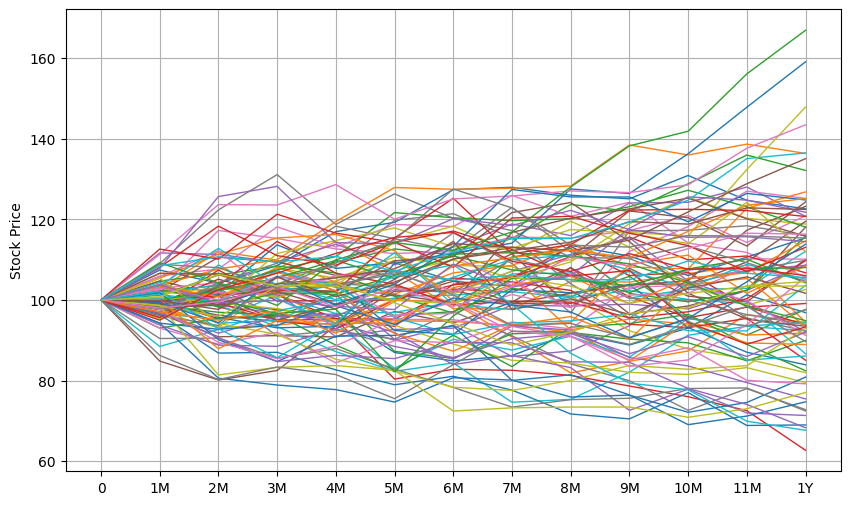

In [455]:
ts = np.linspace(0, T, 13) #change this on monday
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q) # generates Monte Carlo Paths for the stock price

#Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts, paths[:, :100], lw=1) #plot first 100 paths only
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

### Price of European put option (Not used)

In [456]:
np.mean(np.maximum(K-paths[-1], 0))*np.exp(-r*T)

#averaging payoffs of put option at maturity, this is the standard black scholes monte carlo option pricing formula for euro options

np.float64(4.287576125581325)

#### Longstaff-Schwartz algorithm (DEMO)

We use polynomials as basis functions for demonstration purposes.

In [457]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1): #initialize at maturity, go back step by step
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount

    # THE REGRESSION IS DONE HERE -- here, we are simply using polynomial regression 
    # (recall the other methods from ConditionalExpectation.ipynb)
    p = np.polyfit(paths[i], payoff, deg=3)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

np.float64(4.998213044999308)

For your reference, the price of the Bermudan option is $5.152$. In the exercise below, try to see if you can get close to this value (will be helpful for our project later on)

# **Longstaff–Schwartz** Regression Method

We now adapt both the **Longstaff–Schwartz** (LS) algorithm to use three different regression methods:

  1. **Black–Scholes basis**: $\{1,\;P_{\rm BS}(S_{t},K,r,\bar\sigma,\tau)\}$  
     where $P_{\rm BS}$ is the European‐put formula with volatility $\bar\sigma=0.2$ and remaining time $\tau=T-t$.  
  2. **Piecewise‐linear regression** with $J$ knots. (Try different values of $J$)
  3. **Kernel (Nadaraya–Watson)** regression with a Gaussian kernel and bandwidth $h$. (Try different values of $h$).

We first set up our simulation and then define:
- A **Black–Scholes European Pricer** function (GIVEN BELOW),
- (**Task 1**) A **pricers** (`ls_pricer`) that estimates the CONTINUATION VALUE to decide whether or not you will exercise on a certain date.

In [458]:
#black scholes basis
def blackscholes_price(K, T, S0, vol, r=0, q=0, callput='call'):
    F = S0*np.exp((r-q)*T)
    v = vol*np.sqrt(T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v

    cp = callput.lower()
    if cp == 'call':
        opttype = 1
    elif cp == 'put':
        opttype = -1
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

#piecewise linear regression
def pwlin_design(x, knots):
    return np.column_stack([np.ones_like(x), x - knots[0]] + [np.maximum(x - a, 0.0) for a in knots])

#gaussian kernel regression
def gauss_kern(u):
    return np.exp(-0.5 * u**2)


def kern_reg(x, xdata, ydata, bandwidth, eps=1e-12, fallback="mean"):
    """
    Numerically safe Nadaraya–Watson regression with Gaussian kernel.

    If the total kernel weight at a query point is ~0 (underflow / no neighbors),
    it falls back to a stable value to avoid NaNs.
    """
    x = np.asarray(x, dtype=float)
    xdata = np.asarray(xdata, dtype=float)
    ydata = np.asarray(ydata, dtype=float)

    w = gauss_kern((xdata[:, None] - x) / bandwidth)   # (n_train, n_query)
    denom = w.sum(axis=0)                               # (n_query,)
    numer = (w * ydata[:, None]).sum(axis=0)            # (n_query,)

    out = np.empty_like(denom, dtype=float)
    good = denom > eps
    out[good] = numer[good] / denom[good]

    if np.any(~good):
        if fallback == "mean":
            out[~good] = float(np.mean(ydata))
        elif fallback == "nan":
            out[~good] = np.nan
        elif fallback == "nearest":
            # nearest-neighbor fallback (robust, but a bit more compute)
            idx = np.abs(xdata[:, None] - x[None, :]).argmin(axis=0)
            out[~good] = ydata[idx[~good]]
        else:
            raise ValueError("fallback must be one of {'mean','nan','nearest'}")

    return out

#polynomial regression
def poly3_reg(x, xdata, ydata):
    X = np.column_stack([np.ones_like(xdata), xdata, xdata**2, xdata**3])
    beta, *_ = np.linalg.lstsq(X, ydata, rcond=None)
    return beta[0] + beta[1]*x + beta[2]*x**2 + beta[3]*x**3


The Longstaff-Schwartz algorithm provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue. 

**(Task 2)** Perform an independent Monte Carlo simulation using this estimate of continuation value from LS algorithm as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound. Try different methods for regression and compare the results.

Show your code and result with at least 100000 simulations.

In [459]:
# ...existing code...

def train_ls_policy(ts, paths, K, r, q, method='bs', vol_bar=None, J=4, h=5.0): #default values (ignore)
    """Train a Longstaff-Schwartz exercise policy for a Bermudan put.

    Parameters
    ----------
    method : {'bs','pwlin','kernel','poly'}
        Regression/basis method used to approximate continuation values.
    """
    ts = np.asarray(ts, dtype=float)
    if paths.shape[0] != ts.size:
        raise ValueError('paths must have shape (len(ts), n_paths)')

    T = float(ts[-1])
    n_steps = ts.size

    policy = [None] * n_steps
    cashflows = np.maximum(K - paths[-1], 0.0).astype(float)

    sq_error = 0.0
    n_obs = 0

    for i in range(n_steps - 2, 0, -1):
        dt = ts[i + 1] - ts[i]
        if dt <= 0:
            raise ValueError('ts must be strictly increasing')

        cashflows *= np.exp(-r * dt)

        S = paths[i]
        ex = np.maximum(K - S, 0.0)
        itm = ex > 0

        if not np.any(itm):
            policy[i] = {'kind': 'none'}
            continue

        y_itm = cashflows[itm]

        if method == 'bs':
            if vol_bar is None:
                raise ValueError("vol_bar is required when method='bs'")
            tau = T - ts[i]
            x_itm = blackscholes_price(K, tau, S[itm], vol_bar, r, q, 'put')
            X = np.column_stack([np.ones_like(x_itm), x_itm])
            beta, *_ = np.linalg.lstsq(X, y_itm, rcond=None)
            y_hat = X @ beta

            sq_error += float(np.sum((y_itm - y_hat) ** 2))
            n_obs += int(y_itm.size)

            x_all = blackscholes_price(K, tau, S, vol_bar, r, q, 'put')
            cont = beta[0] + beta[1] * x_all
            policy[i] = {'kind': 'linear', 'beta': beta}

        elif method == 'pwlin':
            J = int(J)
            if J < 1:
                raise ValueError('J must be >= 1 for method="pwlin"')
            S_itm = S[itm]

            qs = np.linspace(0.0, 1.0, J + 2)[1:-1]
            knots = np.unique(np.quantile(S_itm, qs))
            if knots.size == 0:
                policy[i] = {'kind': 'none'}
                continue
            else: 
                X = pwlin_design(S_itm, knots)
                beta, *_ = np.linalg.lstsq(X, y_itm, rcond=None)
                y_hat = X @ beta

                sq_error += float(np.sum((y_itm - y_hat) ** 2))
                n_obs += int(y_itm.size)

                cont = pwlin_design(S, knots) @ beta
                policy[i] = {'kind': 'pwlin', 'k': knots, 'beta': beta}

        elif method == 'kernel':
            S_itm = S[itm]
            y_train = y_itm

            # In-sample predictions on ITM points (for MSE reporting)
            y_hat_itm = kern_reg(S_itm, S_itm, y_train, h)
            sq_error += float(np.sum((y_train - y_hat_itm) ** 2))
            n_obs += int(y_train.size)

            # Only need continuation on ITM paths; set OTM cont to +inf so they never "exercise"
            cont = np.full_like(S, np.inf, dtype=float)
            cont[itm] = y_hat_itm

            policy[i] = {'kind': 'kernel', 'S_itm': S_itm, 'y_itm': y_train, 'h': h}

        elif method == 'poly':
            S_itm = S[itm]
            y_train = y_itm

            # in-sample fit quality on ITM points
            y_hat = poly3_reg(S_itm, S_itm, y_train)
            sq_error += float(np.sum((y_train - y_hat) ** 2))
            n_obs += int(y_train.size)

            # continuation for all paths at this time
            cont = poly3_reg(S, S_itm, y_train)

            # store what apply_ls_policy needs
            policy[i] = {'kind': 'poly', 'S_itm': S_itm, 'y_itm': y_train}

        else:
            raise ValueError("method must be one of {'bs','pwlin','kernel','poly'}")

        exercise_now = itm & (ex > cont)
        cashflows[exercise_now] = ex[exercise_now]

    disc0 = np.exp(-r * (ts[1] - ts[0]))
    disc_payoffs = cashflows * disc0

    train_price = float(disc_payoffs.mean())
    std = float(disc_payoffs.std(ddof=1))
    se = std / np.sqrt(disc_payoffs.size)
    ci_low = train_price - 1.96 * se
    ci_high = train_price + 1.96 * se

    mse = (sq_error / n_obs) if n_obs > 0 else float('nan')
    return policy, train_price, mse, ci_low, ci_high





In [460]:
def apply_ls_policy(ts, paths, K, r, q, policy, method='bs', vol_bar=None):
    T = ts[-1]
    n_paths = paths.shape[1]

    exercised = np.zeros(n_paths, dtype=bool)
    exercise_payoffs = np.zeros(n_paths)
    exercise_times = np.zeros(n_paths)

    for i in range(1, len(ts)):
        S = paths[i]
        ex = np.maximum(K - S, 0.0)

        active = ~exercised
        active_idx = np.where(active)[0]
        if active_idx.size == 0:
            break

        if i == len(ts) - 1:
            ex_now = ex[active]
            mask = ex_now > 0
            chosen = active_idx[mask]
            exercise_payoffs[chosen] = ex_now[mask]
            exercise_times[chosen] = ts[i]
            exercised[chosen] = True
            continue

        info = policy[i]
        if info is None or info.get('kind') == 'none':
            continue

        if method == 'bs':
            if vol_bar is None:
                raise ValueError("vol_bar is required when method='bs'")
            tau = T - ts[i]
            bs_vals = blackscholes_price(K, tau, S[active], vol_bar, r, q, 'put')
            beta = info['beta']
            cont = beta[0] + beta[1] * bs_vals

        elif method == 'pwlin':
            k = info['k']
            beta = info['beta']
            cont = pwlin_design(S[active], k) @ beta

        elif method == 'kernel':
            S_train = info['S_itm']
            y_train = info['y_itm']
            h = info['h']

            ex_now = ex[active]
            itm_active = ex_now > 0

            # Default: OTM gets +inf continuation so it can't exercise
            cont = np.full_like(ex_now, np.inf, dtype=float)

            # Only compute kernel continuation where it matters (ITM)
            if np.any(itm_active):
                cont[itm_active] = kern_reg(S[active][itm_active], S_train, y_train, h)
                
        elif method == 'poly':
            S_train = info['S_itm']
            y_train = info['y_itm']
            cont = poly3_reg(S[active], S_train, y_train)

        else:
            raise ValueError("method must be one of {'bs','pwlin','kernel','poly'}")

        ex_now = ex[active]
        mask = (ex_now > 0) & (ex_now > cont)
        chosen = active_idx[mask]

        exercise_payoffs[chosen] = ex_now[mask]
        exercise_times[chosen] = ts[i]
        exercised[chosen] = True

    discount = np.exp(-r * exercise_times)
    disc_payoffs = exercise_payoffs * discount
    price = disc_payoffs.mean()

    std = disc_payoffs.std(ddof=1)
    se = std / np.sqrt(disc_payoffs.size)
    ci_low = price - 1.96 * se
    ci_high = price + 1.96 * se

    return price, ci_low, ci_high


In [461]:
# # ...existing code...

# # collect results so you can plot them
# n_runs = 15
# verbose_per_run = False  # set True if you still want per-run prints

# train_price_bs_arr, mse_bs_arr, lower_bs_arr = [], [], []
# train_price_pw_arr, mse_pw_arr, lower_pw_arr = [], [], []
# train_price_poly_arr, mse_poly_arr, lower_poly_arr = [], [], []
# train_price_kn_arr, mse_kn_arr, lower_kn_arr = [], [], []

# for i in range(n_runs):

#     # Training and test Monte Carlo simulations
#     n_train = 20000
#     n_test = 100000

#     train_paths = blackscholes_mc(ts, n_train, S0, vol, r, q)
#     test_paths = blackscholes_mc(ts, n_test, S0, vol, r, q)

#     # Black–Scholes basis
#     policy_bs, train_price_bs, mse_bs, ci_low_train_bs, ci_high_train_bs = train_ls_policy(
#         ts, train_paths, K, r, q,
#         method='bs', vol_bar=vol
#     )
#     lower_bs, ci_low_test_bs, ci_high_test_bs = apply_ls_policy(
#         ts, test_paths, K, r, q,
#         policy_bs, method='bs', vol_bar=vol
#     )

#     # Piecewise-linear regression
#     policy_pw, train_price_pw, mse_pw, ci_low_train_pw, ci_high_train_pw = train_ls_policy(
#         ts, train_paths, K, r, q,
#         method='pwlin', J=30
#     )
#     lower_pw, ci_low_test_pw, ci_high_test_pw = apply_ls_policy(
#         ts, test_paths, K, r, q,
#         policy_pw, method='pwlin'
#     )

#     # Kernel regression (use smaller train/test inside because it's computationally expensive
#     train_paths_kn = blackscholes_mc(ts, 2000, S0, vol, r, q) 
#     test_paths_kn  = blackscholes_mc(ts, 10000,  S0, vol, r, q)

#     policy_kn, train_price_kn, mse_kn, ci_low_train_kn, ci_high_train_kn = train_ls_policy(
#         ts, train_paths_kn, K, r, q,
#         method='kernel', h=3.0 
#     )
#     lower_kn, ci_low_test_kn, ci_high_test_kn = apply_ls_policy(
#         ts, test_paths_kn, K, r, q,
#         policy_kn, method='kernel'
#     )

#     # Polynomial regression (degree 3)
#     policy_poly, train_price_poly, mse_poly, ci_low_train_poly, ci_high_train_poly = train_ls_policy(
#         ts, train_paths, K, r, q,
#         method='poly'
#     )
#     lower_poly, ci_low_test_poly, ci_high_test_poly = apply_ls_policy(
#         ts, test_paths, K, r, q,
#         policy_poly, method='poly'
#     )

#     if verbose_per_run:
#         print("Training LS prices + MSE:")
#         print(f"   Black–Scholes basis:           price={train_price_bs:.6f}, mse={mse_bs:.6f}")
#         print(f"   Piecewise-linear:              price={train_price_pw:.6f}, mse={mse_pw:.6f}")
#         print(f"   Polynomial regression (deg 3): price={train_price_poly:.6f}, mse={mse_poly:.6f}")
#         print(f"   Kernel regression:             price={train_price_kn:.6f}, mse={mse_kn:.6f}")

#         print("\nLower-bound prices (out-of-sample policy evaluation):")
#         print(f"   Black–Scholes basis:           {lower_bs:.6f}")
#         print(f"   Piecewise-linear:              {lower_pw:.6f}")
#         print(f"   Polynomial regression (deg 3): {lower_poly:.6f}")
#         print(f"   Kernel regression:             {lower_kn:.6f}")
#         print("\n")

#     # store results for plotting / summary
#     train_price_bs_arr.append(train_price_bs); mse_bs_arr.append(mse_bs); lower_bs_arr.append(lower_bs)
#     train_price_pw_arr.append(train_price_pw); mse_pw_arr.append(mse_pw); lower_pw_arr.append(lower_pw)
#     train_price_poly_arr.append(train_price_poly); mse_poly_arr.append(mse_poly); lower_poly_arr.append(lower_poly)
#     train_price_kn_arr.append(train_price_kn); mse_kn_arr.append(mse_kn); lower_kn_arr.append(lower_kn)

# # convert to numpy arrays (length = n_runs)
# train_price_bs_arr = np.asarray(train_price_bs_arr); mse_bs_arr = np.asarray(mse_bs_arr); lower_bs_arr = np.asarray(lower_bs_arr)
# train_price_pw_arr = np.asarray(train_price_pw_arr); mse_pw_arr = np.asarray(mse_pw_arr); lower_pw_arr = np.asarray(lower_pw_arr)
# train_price_poly_arr = np.asarray(train_price_poly_arr); mse_poly_arr = np.asarray(mse_poly_arr); lower_poly_arr = np.asarray(lower_poly_arr)
# train_price_kn_arr = np.asarray(train_price_kn_arr); mse_kn_arr = np.asarray(mse_kn_arr); lower_kn_arr = np.asarray(lower_kn_arr)

# # handy matrices for plotting: columns = [bs, pwlin, poly, kernel]
# labels = ["bs", "pwlin", "poly", "kernel"]
# train_prices_mat = np.column_stack([train_price_bs_arr, train_price_pw_arr, train_price_poly_arr, train_price_kn_arr])
# mses_mat = np.column_stack([mse_bs_arr, mse_pw_arr, mse_poly_arr, mse_kn_arr])
# lower_prices_mat = np.column_stack([lower_bs_arr, lower_pw_arr, lower_poly_arr, lower_kn_arr])

# # ---- NEW: print MEANS in the original format across n_runs ----
# print(f"MEAN results across n_runs={n_runs} independent runs")
# print("Training LS prices + MSE:")
# print(f"   Black–Scholes basis:           price={train_price_bs_arr.mean():.6f}, mse={mse_bs_arr.mean():.6f}")
# print(f"   Piecewise-linear:              price={train_price_pw_arr.mean():.6f}, mse={mse_pw_arr.mean():.6f}")
# print(f"   Polynomial regression (deg 3): price={train_price_poly_arr.mean():.6f}, mse={mse_poly_arr.mean():.6f}")
# print(f"   Kernel regression:             price={train_price_kn_arr.mean():.6f}, mse={mse_kn_arr.mean():.6f}")

# print("\nLower-bound prices (out-of-sample policy evaluation):")
# print(f"   Black–Scholes basis:           {lower_bs_arr.mean():.6f}")
# print(f"   Piecewise-linear:              {lower_pw_arr.mean():.6f}")
# print(f"   Polynomial regression (deg 3): {lower_poly_arr.mean():.6f}")
# print(f"   Kernel regression:             {lower_kn_arr.mean():.6f}")

# print("\nSaved arrays for plotting:")
# print("  labels =", labels)
# print("  train_prices_mat shape =", train_prices_mat.shape)
# print("  mses_mat shape         =", mses_mat.shape)
# print("  lower_prices_mat shape =", lower_prices_mat.shape)

# # ...existing code...

In [462]:

# # === Plotting results across runs ===
# import numpy as np
# import matplotlib.pyplot as plt

# # sanity
# assert train_prices_mat.shape == lower_prices_mat.shape == mses_mat.shape
# n_runs, n_methods = train_prices_mat.shape
# x = np.arange(n_methods)

# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # (1) Boxplots: distribution across runs
# axes[0].boxplot([train_prices_mat[:, j] for j in range(n_methods)], labels=labels, showmeans=True)
# axes[0].set_title("Training LS price (in-sample) across runs")
# axes[0].set_ylabel("Price")
# axes[0].grid(True, alpha=0.3)

# axes[1].boxplot([lower_prices_mat[:, j] for j in range(n_methods)], labels=labels, showmeans=True)
# axes[1].set_title("Lower-bound price (out-of-sample policy eval) across runs")
# axes[1].set_ylabel("Price")
# axes[1].grid(True, alpha=0.3)

# # (2) Scatter: MSE vs lower bound (one cloud per method)
# for j, lab in enumerate(labels):
#     axes[2].scatter(mses_mat[:, j], lower_prices_mat[:, j], s=30, alpha=0.8, label=lab)
# axes[2].set_title("MSE (train) vs lower-bound price (test)")
# axes[2].set_xlabel("Train MSE on ITM paths")
# axes[2].set_ylabel("Lower-bound price")
# axes[2].grid(True, alpha=0.3)
# axes[2].legend()

# plt.tight_layout()
# plt.show()

# # (3) Optional: per-run lines (see stability)
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# for j, lab in enumerate(labels):
#     ax.plot(np.arange(n_runs), lower_prices_mat[:, j], marker="o", lw=1.5, label=lab)
# ax.set_title("Lower-bound price per run (out-of-sample)")
# ax.set_xlabel("Run index")
# ax.set_ylabel("Price")
# ax.grid(True, alpha=0.3)
# ax.legend()
# plt.tight_layout()
# plt.show()

# # (4) Optional summary: mean +/- 1 std error bars
# means = lower_prices_mat.mean(axis=0)
# stds = lower_prices_mat.std(axis=0, ddof=1)

# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.bar(x, means, yerr=stds, capsize=6, alpha=0.85)
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.set_title("Lower-bound price: mean ± 1 std (across runs)")
# ax.set_ylabel("Price")
# ax.grid(True, axis="y", alpha=0.3)
# plt.tight_layout()
# plt.show()
# # ...existing code...

## Model Parameter Optimization ##

In [463]:

# # === Piecewise-linear (pwlin) sweep over number of knots J ===

# # how many independent repetitions
# n_runs = 15

# # sweep these knot counts (edit as you like)
# J_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# # Monte Carlo sizes (same as your main experiment)
# n_train = 20000
# n_test = 100000

# n_J = len(J_grid)

# # store results: shape = (n_runs, n_J)
# pw_train_prices = np.full((n_runs, n_J), np.nan)
# pw_mses = np.full((n_runs, n_J), np.nan)
# pw_lower_prices = np.full((n_runs, n_J), np.nan)

# # also store the *actual* average number of knots used per time step (duplicates can reduce it)
# pw_avg_knots_used = np.full((n_runs, n_J), np.nan)

# for run in range(n_runs):

#     train_paths = blackscholes_mc(ts, n_train, S0, vol, r, q)
#     test_paths  = blackscholes_mc(ts, n_test,  S0, vol, r, q)

#     for j_idx, J in enumerate(J_grid):

#         policy_pw, train_price_pw, mse_pw, ci_low_train_pw, ci_high_train_pw = train_ls_policy(
#             ts, train_paths, K, r, q,
#             method='pwlin', J=J
#         )
#         lower_pw, ci_low_test_pw, ci_high_test_pw = apply_ls_policy(
#             ts, test_paths, K, r, q,
#             policy_pw, method='pwlin'
#         )

#         pw_train_prices[run, j_idx] = train_price_pw
#         pw_mses[run, j_idx] = mse_pw
#         pw_lower_prices[run, j_idx] = lower_pw

#         # average *actual* number of knots stored in the learned policy across time steps
#         knot_counts = []
#         for i in range(1, len(ts) - 1):
#             info = policy_pw[i]
#             if info is not None and info.get('kind') == 'pwlin':
#                 knot_counts.append(len(info['k']))
#         pw_avg_knots_used[run, j_idx] = (np.mean(knot_counts) if len(knot_counts) > 0 else 0.0)

# # ---- Plotting ----

# J_arr = np.asarray(J_grid)

# # 1) Mean +/- std across runs (lower bound, train price, and MSE)
# lower_mean = pw_lower_prices.mean(axis=0)
# lower_std  = pw_lower_prices.std(axis=0, ddof=1)

# train_mean = pw_train_prices.mean(axis=0)
# train_std  = pw_train_prices.std(axis=0, ddof=1)

# mse_mean = pw_mses.mean(axis=0)
# mse_std  = pw_mses.std(axis=0, ddof=1)

# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# axes[0].errorbar(J_arr, mse_mean, yerr=mse_std, fmt='o-', capsize=4)
# axes[0].set_title("Piecewise-linear: Train MSE vs #knots (J)")
# axes[0].set_xlabel("J (requested #knots)")
# axes[0].set_ylabel("Train MSE (ITM)")
# axes[0].grid(True, alpha=0.3)

# axes[1].errorbar(J_arr, train_mean, yerr=train_std, fmt='o-', capsize=4)
# axes[1].set_title("Piecewise-linear: Training LS price vs #knots (J)")
# axes[1].set_xlabel("J (requested #knots)")
# axes[1].set_ylabel("Training LS price")
# axes[1].grid(True, alpha=0.3)

# axes[2].errorbar(J_arr, lower_mean, yerr=lower_std, fmt='o-', capsize=4)
# axes[2].set_title("Piecewise-linear: Lower-bound price vs #knots (J)")
# axes[2].set_xlabel("J (requested #knots)")
# axes[2].set_ylabel("Lower-bound price")
# axes[2].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # 2) Boxplot of lower-bound prices across runs for each J
# fig, ax = plt.subplots(1, 1, figsize=(12, 5))
# ax.boxplot([pw_lower_prices[:, k] for k in range(n_J)], labels=J_grid, showmeans=True)
# ax.set_title("Piecewise-linear: Lower-bound price distribution across runs (by J)")
# ax.set_xlabel("J (requested #knots)")
# ax.set_ylabel("Lower-bound price")
# ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()



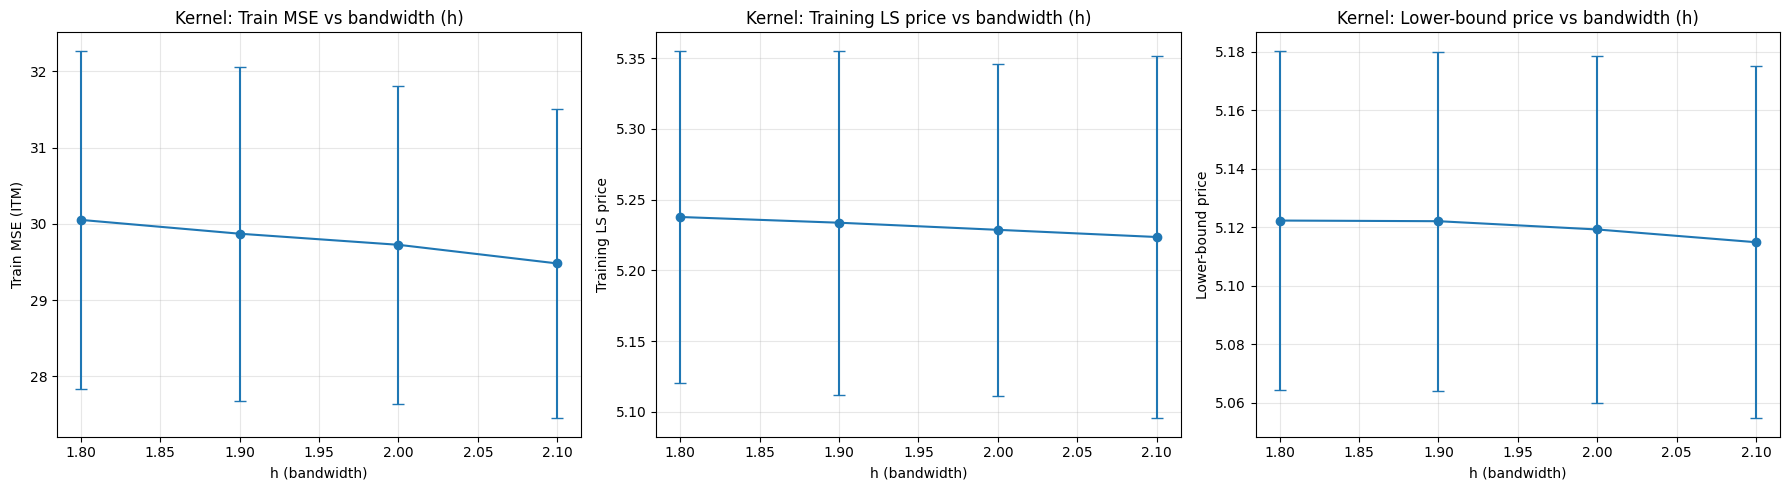

C:\Users\Matthew S\AppData\Local\Temp\ipykernel_10964\3871610949.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([kn_lower_prices[:, k] for k in range(n_h)], labels=[str(h) for h in h_grid], showmeans=True)


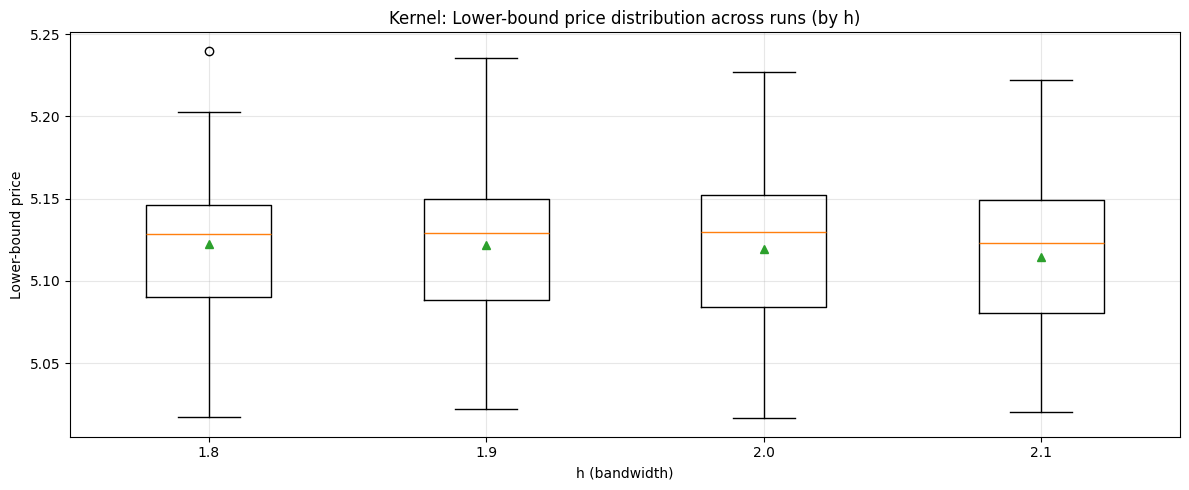

Best h by mean lower-bound across runs: h=1.8 (mean lower=5.122225)


In [ ]:
# ...existing code...

# === Kernel regression (kernel) sweep over bandwidth h ===

# how many independent repetitions
n_runs = 15

# sweep these bandwidths (edit as you like)
h_grid = [1.8]

# Monte Carlo sizes (kernel is expensive: keep these smaller than other methods)
n_train_kn = 5000
n_test_kn  = 40000

n_h = len(h_grid)

# store results: shape = (n_runs, n_h)
kn_train_prices = np.full((n_runs, n_h), np.nan)
kn_mses         = np.full((n_runs, n_h), np.nan)
kn_lower_prices = np.full((n_runs, n_h), np.nan)

for run in range(n_runs):
    train_paths_kn = blackscholes_mc(ts, n_train_kn, S0, vol, r, q)
    test_paths_kn  = blackscholes_mc(ts, n_test_kn,  S0, vol, r, q)

    for h_idx, h in enumerate(h_grid):
        policy_kn, train_price_kn, mse_kn, ci_low_train_kn, ci_high_train_kn = train_ls_policy(
            ts, train_paths_kn, K, r, q,
            method='kernel', h=float(h)
        )
        lower_kn, ci_low_test_kn, ci_high_test_kn = apply_ls_policy(
            ts, test_paths_kn, K, r, q,
            policy_kn, method='kernel'
        )

        kn_train_prices[run, h_idx] = train_price_kn
        kn_mses[run, h_idx]         = mse_kn
        kn_lower_prices[run, h_idx] = lower_kn

# ---- Plotting ----
h_arr = np.asarray(h_grid, dtype=float)

# Mean +/- std across runs (lower bound, train price, and MSE)
lower_mean = kn_lower_prices.mean(axis=0)
lower_std  = kn_lower_prices.std(axis=0, ddof=1)

train_mean = kn_train_prices.mean(axis=0)
train_std  = kn_train_prices.std(axis=0, ddof=1)

mse_mean = kn_mses.mean(axis=0)
mse_std  = kn_mses.std(axis=0, ddof=1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].errorbar(h_arr, mse_mean, yerr=mse_std, fmt='o-', capsize=4)
axes[0].set_title("Kernel: Train MSE vs bandwidth (h)")
axes[0].set_xlabel("h (bandwidth)")
axes[0].set_ylabel("Train MSE (ITM)")
axes[0].grid(True, alpha=0.3)

axes[1].errorbar(h_arr, train_mean, yerr=train_std, fmt='o-', capsize=4)
axes[1].set_title("Kernel: Training LS price vs bandwidth (h)")
axes[1].set_xlabel("h (bandwidth)")
axes[1].set_ylabel("Training LS price")
axes[1].grid(True, alpha=0.3)

axes[2].errorbar(h_arr, lower_mean, yerr=lower_std, fmt='o-', capsize=4)
axes[2].set_title("Kernel: Lower-bound price vs bandwidth (h)")
axes[2].set_xlabel("h (bandwidth)")
axes[2].set_ylabel("Lower-bound price")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Boxplot of lower-bound prices across runs for each h
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.boxplot([kn_lower_prices[:, k] for k in range(n_h)], labels=[str(h) for h in h_grid], showmeans=True)
ax.set_title("Kernel: Lower-bound price distribution across runs (by h)")
ax.set_xlabel("h (bandwidth)")
ax.set_ylabel("Lower-bound price")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: report the best h by mean lower bound (across runs)
best_idx = int(np.argmax(lower_mean))
print(f"Best h by mean lower-bound across runs: h={h_grid[best_idx]} (mean lower={lower_mean[best_idx]:.6f})")

# ...existing code...